In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
sns.set_theme(style="white")

import pickle

ModuleNotFoundError: No module named 'sklearn'

In [27]:
tavg = pd.read_csv("new_england_tavg.csv", index_col=0, parse_dates=True).squeeze("columns")
tmax = pd.read_csv("new_england_tmax.csv", index_col=0, parse_dates=True).squeeze("columns")
tmin = pd.read_csv("new_england_tmin.csv", index_col=0, parse_dates=True).squeeze("columns")
season = pd.read_csv("tavg_season_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
trend = pd.read_csv("tavg_trend_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
resid = pd.read_csv("tavg_resid_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
prcp = pd.read_csv("new_england_prcp.csv", index_col=1, parse_dates=True)
prcp = prcp["measurement"].squeeze()
prcp

date
1951-01-01    0.33
1951-01-02    0.00
1951-01-03    0.22
1951-01-04    2.43
1951-01-05    1.05
              ... 
2021-12-27    0.08
2021-12-28    0.80
2021-12-29    1.97
2021-12-30    0.49
2021-12-31    0.59
Name: measurement, Length: 25933, dtype: float64

Now we plot auto correlation, which is the correlation between time t and a delayed version of itself.
In this case we plot the correlation between tavg and any point in time up to 1000 days in the past.
the light blue indicates statistical significance.

Now it's time to create a dataset with predictions, we start by using only the most recent data to predict the tavg a day or 2 in advance

In [38]:
# Copied from https://github.com/vcerqueira. this code allows us to create lags and a prediction horizon
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X




In [39]:
# applying time delay embedding
# exampl using 3 lags (n_lags=3) to predict the next value (horizon=1)
ts = time_delay_embedding(series=series, n_lags=30, horizon=3)
ts

,measurement(t-29),measurement(t-28),measurement(t-27),measurement(t-26),measurement(t-25),measurement(t-24),measurement(t-23),measurement(t-22),measurement(t-21),measurement(t-20),...,measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0),measurement(t+1),measurement(t+2),measurement(t+3)
date,,,,,,,,,,,,,,,,,,,,,
1951-01-31,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34
1951-02-01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93
1951-02-02,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49
1951-02-03,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49,-8.94
1951-02-04,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49,-8.94,-7.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,-1.43,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,...,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83
2021-12-26,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,...,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98
2021-12-27,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,-1.82,...,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98,-1.90


we split the columns that have a "+" in them, these are our target values 

In [40]:
# splitting target variable from explanatory variables
target_columns = ts.columns.str.contains('\+')
X = ts.iloc[:, ~target_columns]
y = ts[['measurement(t+1)','measurement(t+2)','measurement(t+3)' ]]
X

,measurement(t-29),measurement(t-28),measurement(t-27),measurement(t-26),measurement(t-25),measurement(t-24),measurement(t-23),measurement(t-22),measurement(t-21),measurement(t-20),...,measurement(t-9),measurement(t-8),measurement(t-7),measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0)
date,,,,,,,,,,,,,,,,,,,,,
1951-01-31,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,0.63,-8.11,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32
1951-02-01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-8.11,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08
1951-02-02,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04
1951-02-03,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34
1951-02-04,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,-1.43,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,...,-1.06,-0.93,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97
2021-12-26,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,...,-0.93,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30
2021-12-27,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,-1.82,...,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11


In [41]:
y

,measurement(t+1),measurement(t+2),measurement(t+3)
date,,,
1951-01-31,-19.08,-12.04,-3.34
1951-02-01,-12.04,-3.34,-10.93
1951-02-02,-3.34,-10.93,-9.49
1951-02-03,-10.93,-9.49,-8.94
1951-02-04,-9.49,-8.94,-7.71
...,...,...,...
2021-12-25,-8.30,-4.11,-2.83
2021-12-26,-4.11,-2.83,-3.98
2021-12-27,-2.83,-3.98,-1.90


Now time to split into train test

In [42]:

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.33, shuffle=False)


In [43]:
y_ts

,measurement(t+1),measurement(t+2),measurement(t+3)
date,,,
1998-08-05,19.84,20.85,21.17
1998-08-06,20.85,21.17,21.08
1998-08-07,21.17,21.08,22.45
1998-08-08,21.08,22.45,23.49
1998-08-09,22.45,23.49,23.81
...,...,...,...
2021-12-25,-8.30,-4.11,-2.83
2021-12-26,-4.11,-2.83,-3.98
2021-12-27,-2.83,-3.98,-1.90


In [17]:
#fitting a random forest
#Instead of running this just use the next cell to load the model

# model = RandomForestRegressor(verbose=1)
# model.fit(X_tr, y_tr)
# model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.1s finished


RandomForestRegressor(verbose=1)

In [18]:
# load the model from disk, github won't let me upload this so you will have to train it yourself
model = pickle.load(open("03_random_forest.sav", 'rb'))
model

In [44]:
# save the model to disk

# filename = '03_random_forest.sav'
# pickle.dump(model, open(filename, 'wb'))



In [51]:
# getting forecasts for the test set
predictions = model.predict(X_ts)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [52]:
predictions = pd.DataFrame(predictions, columns = ['one day','two days','three days'])
predictions

,one day,two days,three days
0,19.7341,19.1311,18.6683
1,19.2493,19.0220,18.8020
2,20.2546,19.7445,19.5914
3,20.9343,20.5840,20.2866
4,20.3329,19.5440,19.2440
...,...,...,...
8543,-9.2313,-7.6948,-6.8481
8544,-6.6468,-6.1038,-5.7641
8545,-4.0001,-4.3688,-4.0113
8546,-2.8866,-2.5877,-3.3958


In [53]:
y = y_ts["measurement(t+1)"].reset_index(drop=True)
x = predictions["one day"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")

2.135134124941507

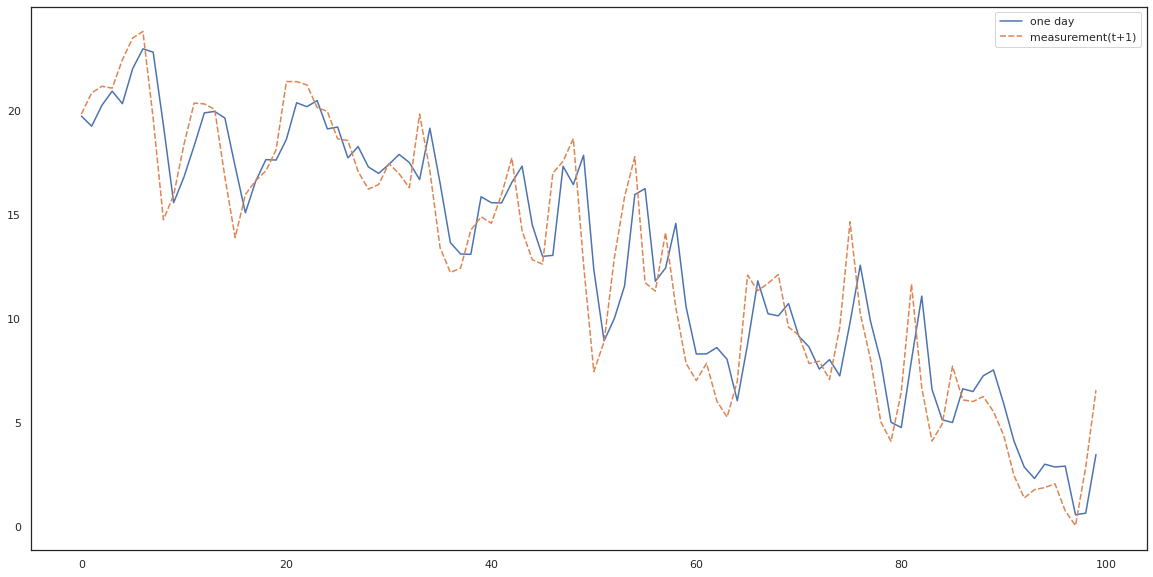

In [54]:
sns.lineplot(data=results_one_ahead[:100])
# computing MAE error
mae(y,x)

3.049362388862892

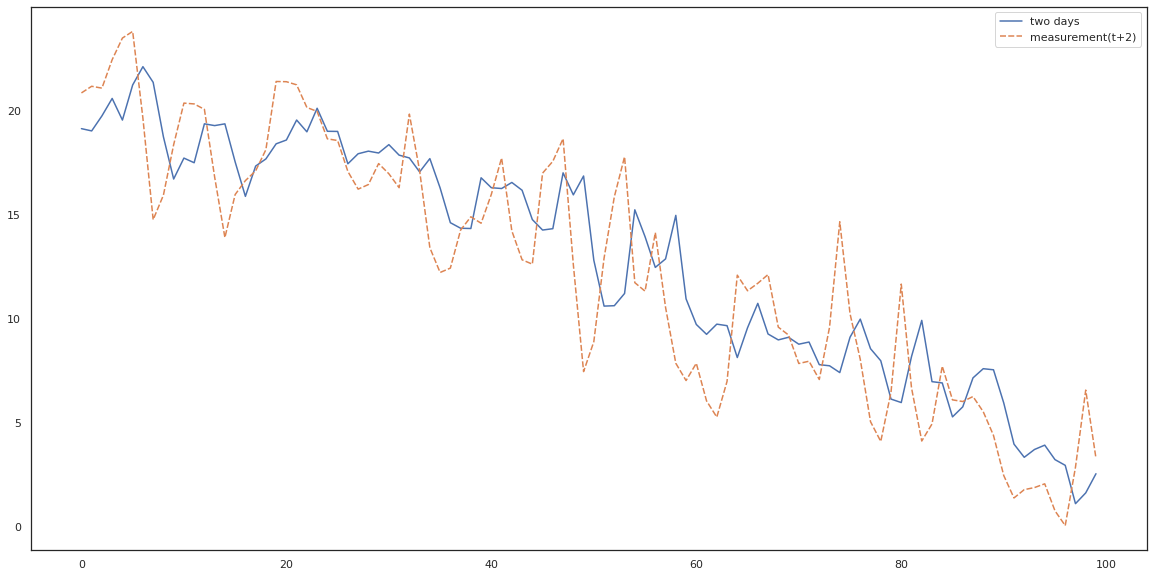

In [55]:
y = y_ts["measurement(t+2)"].reset_index(drop=True)
x = predictions["two days"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")
sns.lineplot(data=results_one_ahead[:100])
mae(y,x)

3.3178910856340664

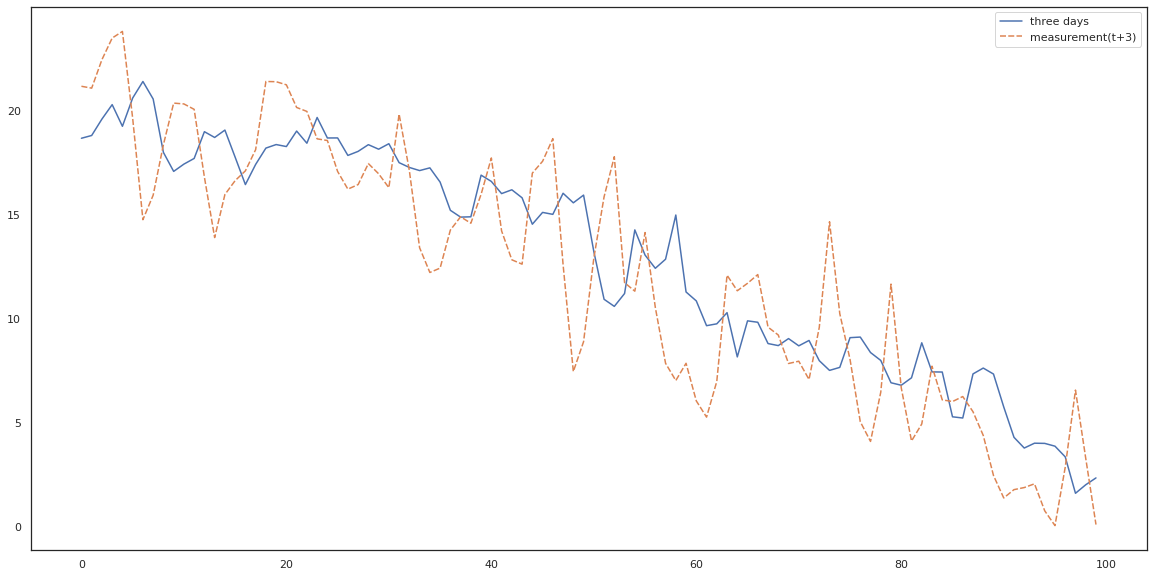

In [56]:
y = y_ts["measurement(t+3)"].reset_index(drop=True)
x = predictions["three days"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")
sns.lineplot(data=results_one_ahead[:100])
mae(y,x)